# Descripcion del proyecto

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

# Inicialización

In [61]:
# Cargamos todas las librerias que creemos que vamos a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Preparación de datos

In [62]:
#Cargamos los datos
df = pd.read_csv('/datasets/car_data.csv')

In [63]:
#validamos las dimensiones del dataframe (usamos shape) e imprimimos las primeras filas (usamos head)
print(df.shape)
print(df.head())
print()
#mostramos la informacion del dataframe con el metodo info
df.info()

(354369, 16)
        DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  24/03/2016 11:52    480         NaN              1993  manual      0   
1  24/03/2016 10:58  18300       coupe              2011  manual    190   
2  14/03/2016 12:52   9800         suv              2004    auto    163   
3  17/03/2016 16:54   1500       small              2001  manual     75   
4  31/03/2016 17:25   3600       small              2008  manual     69   

   Model  Mileage  RegistrationMonth  FuelType       Brand NotRepaired  \
0   golf   150000                  0    petrol  volkswagen         NaN   
1    NaN   125000                  5  gasoline        audi         yes   
2  grand   125000                  8  gasoline        jeep         NaN   
3   golf   150000                  6    petrol  volkswagen          no   
4  fabia    90000                  7  gasoline       skoda          no   

        DateCreated  NumberOfPictures  PostalCode          LastSeen  
0  24/03/2016 00:00  

In [64]:
#Renombramos las columnas para que el código se vea más coherente con su estilo.
df = df.rename(columns={'DateCrawled': 'date_crawled', 'Price': 'price', 'VehicleType': 'vehicle_type', 'RegistrationYear': 'registration_year',
                        'Gearbox': 'gearbox', 'Power': 'power', 'Model': 'model', 'Mileage': 'mileage', 'RegistrationMonth': 'registration_month',
                        'FuelType': 'fuel_type', 'Brand': 'brand', 'NotRepaired': 'not_repaired', 'DateCreated': 'date_created',
                        'NumberOfPictures': 'number_of_pictures', 'PostalCode': 'postal_code', 'LastSeen': 'last_seen'})

#Validamos los cambios con el metodo info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [65]:
# Eliminamos las columnas innecesarias para nuestro modelo
df = df.drop(['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)

#Validamos los cambios con el metodo info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354369 non-null  int64 
 1   vehicle_type        316879 non-null  object
 2   registration_year   354369 non-null  int64 
 3   gearbox             334536 non-null  object
 4   power               354369 non-null  int64 
 5   model               334664 non-null  object
 6   mileage             354369 non-null  int64 
 7   registration_month  354369 non-null  int64 
 8   fuel_type           321474 non-null  object
 9   brand               354369 non-null  object
 10  not_repaired        283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


se realiza la validacion del dataframe a traves del metodo info para tener una vista inicial de los datos, se procedió a cambiar el nombre de las columnas para que se vea mas coherente ya que algunas columnas cuentan con mayusculas y espacios. se procedió a eliminar las columnas ('date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen') que inicialmente consideramos son innecesarias para nuestro modelo ya que no cuentan con informacion relevante.

### Resumen estadístico de las variables

In [66]:
#Mostramos un resumen estadístico de las variables utilizando el metodo describe
print(df.describe())

               price  registration_year          power        mileage  \
count  354369.000000      354369.000000  354369.000000  354369.000000   
mean     4416.656776        2004.234448     110.094337  128211.172535   
std      4514.158514          90.227958     189.850405   37905.341530   
min         0.000000        1000.000000       0.000000    5000.000000   
25%      1050.000000        1999.000000      69.000000  125000.000000   
50%      2700.000000        2003.000000     105.000000  150000.000000   
75%      6400.000000        2008.000000     143.000000  150000.000000   
max     20000.000000        9999.000000   20000.000000  150000.000000   

       registration_month  
count       354369.000000  
mean             5.714645  
std              3.726421  
min              0.000000  
25%              3.000000  
50%              6.000000  
75%              9.000000  
max             12.000000  


### Duplicados

In [67]:
# validamos si tenemos valores duplicados en el dataframe con el metodo duplicated
print(df.duplicated().sum())

#mostramos los duplicados
print(df[df.duplicated()])

27543
        price vehicle_type  registration_year gearbox  power      model  \
1396        0          NaN               2000     NaN      0        NaN   
3025     2800        wagon               2005     NaN      0     touran   
3458      300        small               2000  manual     54      corsa   
3551     1670        sedan               1999  manual     75       golf   
3786     2999        sedan               2002  manual    101       golf   
...       ...          ...                ...     ...    ...        ...   
354336   3299          NaN               2005    auto      0  outlander   
354337  11500        sedan               2004    auto    445        7er   
354352   6500        sedan               2003    auto    145   e_klasse   
354355   4400        sedan               2008  manual    105       leon   
354363   1150          bus               2000  manual      0     zafira   

        mileage  registration_month fuel_type          brand not_repaired  
1396     150000  

In [68]:
#eliminamos las filas duplicadas
df.drop_duplicates(inplace=True)

#validamos nuevamente el numero de duplicados
print(df.duplicated().sum())

0


### Valores ausentes

In [69]:
#validamos si tenemos valores ausentes con el metodo isna
print(df.isna().sum())

price                     0
vehicle_type          35249
registration_year         0
gearbox               17578
power                     0
model                 18532
mileage                   0
registration_month        0
fuel_type             31122
brand                     0
not_repaired          66427
dtype: int64


In [70]:
#validamos el porcentaje de los valores ausentes por columna 
df.isna().sum()/df.shape[0]*100

price                  0.000000
vehicle_type          10.785250
registration_year      0.000000
gearbox                5.378397
power                  0.000000
model                  5.670296
mileage                0.000000
registration_month     0.000000
fuel_type              9.522498
brand                  0.000000
not_repaired          20.324882
dtype: float64

In [71]:
# eliminamos los valores ausentes de las columnas gearbox y model
df.dropna(subset=['gearbox', 'model'], inplace = True)

In [72]:
# remplazamos los valores ausentes de las columnas vehicle_type y fuel_type  por 'unknown'
df['vehicle_type'].fillna('unknown', inplace = True)
df['fuel_type'].fillna('unknown', inplace = True)

In [73]:
#validamos la cantidad de vehiculos que tienen o no reparaciones
df['not_repaired'].value_counts()

no     213578
yes     30874
Name: not_repaired, dtype: int64

In [74]:
# remplazamos los valores ausentes de la columna not_repaired por 'no'
df['not_repaired'].fillna('no', inplace = True)

In [75]:
# validamos nuevamente si tenemos valores ausentes
print(df.isna().sum())

df.info()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
mileage               0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 294249 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               294249 non-null  int64 
 1   vehicle_type        294249 non-null  object
 2   registration_year   294249 non-null  int64 
 3   gearbox             294249 non-null  object
 4   power               294249 non-null  int64 
 5   model               294249 non-null  object
 6   mileage             294249 non-null  int64 
 7   registration_month  294249 non-null  int64 
 8   fuel_type           294249 non-null  object
 9   brand               294249 non-null  object
 10  not_repaired       

se validó si contamos con filas duplicadas, lo cual nos arrojo un valor de 27543, los cuales se proceden a eliminar ya que hay múltiples entradas con la misma información en todas las columnas, esto nos dice que no hay variación en los datos de esos vehículos, lo que sugiere que representan el mismo vehículo.

se verificó los valores ausentes en el dataframe, el cual nos arrojo valores en las columnas 'gearbox', 'model', 'vehicle_type', 'fuel_type' y not_repaired; se procedio a eliminar los valores ausentes de las columnas 'gearbox', 'model' ya que representan un porcertaje muy bajo (5.6%), a las columnas 'vehicle_type' y 'fuel_type' se rellenaron los valores ausentes con la palabra unknown, ya que no se considera viable eliminar dichos valores porque dichas caracteristicas pueden influir altamente en el precio del vehiculo.

Para la columna not_repaired se procede a validar y el valor mas representativo es 'no' (vehiculos no han sido reparados), por lo cual se tomo este valor para rellenar los valores ausentes.

### Análisis de las columnas registration_year, brand y model

#### registration_year

In [76]:
#validamos los valores unicos de la columna registration_year
print(df['registration_year'].sort_values().unique())

[1000 1200 1400 1500 1600 1602 1910 1919 1923 1927 1928 1929 1930 1931
 1932 1933 1934 1935 1936 1937 1938 1942 1943 1945 1947 1950 1951 1952
 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966
 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980
 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2900 3000 3700
 4000 4500 5000 5911 6000 6500 7100 7500 8200 9000]


In [77]:
#filtramos el dataframe solo con los años relevantes
df = df[(df['registration_year'] > 1909) & (df['registration_year'] < 2020)]

#### brand

In [78]:
#validamos los valores unicos de la columna brand
print(df['brand'].sort_values().unique())

['alfa_romeo' 'audi' 'bmw' 'chevrolet' 'chrysler' 'citroen' 'dacia'
 'daewoo' 'daihatsu' 'fiat' 'ford' 'honda' 'hyundai' 'jaguar' 'jeep' 'kia'
 'lada' 'lancia' 'land_rover' 'mazda' 'mercedes_benz' 'mini' 'mitsubishi'
 'nissan' 'opel' 'peugeot' 'porsche' 'renault' 'rover' 'saab' 'seat'
 'skoda' 'smart' 'subaru' 'suzuki' 'toyota' 'trabant' 'volkswagen' 'volvo']


In [79]:
# Contamos las marcas y obtenemos las 10 más comunes
top_brands = df['brand'].value_counts().nlargest(10).index

# Reemplazamos las marcas que no están en las top 10 con 'other'
df['brand'] = df['brand'].apply(lambda x: x if x in top_brands else 'other')

# Ahora puedes verificar el resultado
print(df['brand'].value_counts())

volkswagen       63410
other            54946
opel             33152
bmw              30997
mercedes_benz    27627
audi             24841
ford             21272
renault          15057
peugeot           8986
fiat              7981
seat              5957
Name: brand, dtype: int64


In [80]:
#validamos nuevamente los valores unicos de la columna brand
print(df['brand'].sort_values().unique())

['audi' 'bmw' 'fiat' 'ford' 'mercedes_benz' 'opel' 'other' 'peugeot'
 'renault' 'seat' 'volkswagen']


#### model

In [81]:
#validamos los valores unicos de la columna model
print(df['model'].sort_values().unique())

['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour' 'fortwo' 'fox' 'freelander' 'fusion' 'g_klasse' 'galant'
 'galaxy' 'getz' 'gl' 'glk' 'golf' 'grand' 'i3' 'i_reihe' 'ibiza'
 'impreza' '

In [82]:
# Omitimos la columna 'model' del DataFrame
df = df.drop('model', axis = 1)

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294226 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               294226 non-null  int64 
 1   vehicle_type        294226 non-null  object
 2   registration_year   294226 non-null  int64 
 3   gearbox             294226 non-null  object
 4   power               294226 non-null  int64 
 5   mileage             294226 non-null  int64 
 6   registration_month  294226 non-null  int64 
 7   fuel_type           294226 non-null  object
 8   brand               294226 non-null  object
 9   not_repaired        294226 non-null  object
dtypes: int64(5), object(5)
memory usage: 24.7+ MB


Se realiza la validacion de la columna registration_year y se evidencia que hay años irrelevantes(años muy antiguos o valores ilogicos) para lo cual se filtra el dataframe dejando solo los años relevantes (1909 a 2019), se eliminan registros que probablemente no representan vehículos válidos.

De la columna brand se validan los valores unicos para conocer la variedad de las marcas, al haber muchas marcas se procede a hallar las 10 marcas mas relevantes para una interpretacion mas clara, las marcas que no se encuentren entre las 10 mas comunes se remplazaron por el nombre 'other'. esto podria evitar que el modelo se vea afectado por marcas que tienen pocos registros.

Se decidió omitir la columna 'model' del análisis debido a la gran cantidad de categorías únicas (mas de 200). Esto podría introducir complejidad innecesaria al modelo y potencialmente llevarlo al sobreajuste.

## Entrenamiento del modelo 

### Procesamiento de caracteristicas

In [84]:
#usamos la tecnica One-Hot Encoding para procesar caracteristicas categoricas
df_ohe = pd.get_dummies(df, drop_first= True)
print(df_ohe.head())

   price  registration_year  power  mileage  registration_month  \
0    480               1993      0   150000                   0   
2   9800               2004    163   125000                   8   
3   1500               2001     75   150000                   6   
4   3600               2008     69    90000                   7   
5    650               1995    102   150000                  10   

   vehicle_type_convertible  vehicle_type_coupe  vehicle_type_other  \
0                         0                   0                   0   
2                         0                   0                   0   
3                         0                   0                   0   
4                         0                   0                   0   
5                         0                   0                   0   

   vehicle_type_sedan  vehicle_type_small  ...  brand_fiat  brand_ford  \
0                   0                   0  ...           0           0   
2                   0 

In [85]:
#estandarizamos los datos de las caracteristicas numericas con el escalado de caracteristicas

# definimos las columnas numéricas que necesitan escalado
numerical_columns = ['registration_year', 'power', 'mileage', 'registration_month']

scaler = StandardScaler() #creamos la instancia del escalador

# Ajustamos el escalador a los datos y transformar las columnas numéricas
df_ohe[numerical_columns] = scaler.fit_transform(df_ohe[numerical_columns])

# mostramos los datos escalados
print(df_ohe.head())

   price  registration_year     power   mileage  registration_month  \
0    480          -1.454668 -0.599406  0.577726           -1.617857   
2   9800           0.113121  0.251886 -0.103931            0.580878   
3   1500          -0.314458 -0.207707  0.577726            0.031194   
4   3600           0.683226 -0.239043 -1.058251            0.306036   
5    650          -1.169616 -0.066695  0.577726            1.130561   

   vehicle_type_convertible  vehicle_type_coupe  vehicle_type_other  \
0                         0                   0                   0   
2                         0                   0                   0   
3                         0                   0                   0   
4                         0                   0                   0   
5                         0                   0                   0   

   vehicle_type_sedan  vehicle_type_small  ...  brand_fiat  brand_ford  \
0                   0                   0  ...           0           0  

Se utilizó la técnica de One-Hot Encoding para procesar las características categóricas mediante pd.get_dummies(). Esta transformación es esencial para varios de los modelos que vamos a entrenar, como la Regresión Lineal, Árbol de Decisión, Bosque Aleatorio y XGBoost, ya que no pueden manejar directamente las características categóricas.

Además, se estandarizaron las características numéricas utilizando StandardScaler(). Este escalado asegura que todas las características se traten con igual importancia durante el entrenamiento

### Entrenamiento y prueba de modelos 

In [86]:
# Separamos características y objetivo
X = df_ohe.drop(['price', 'registration_month'], axis=1)
y = df_ohe['price']

# División en conjunto de entrenamiento (75%) y validacion (25%)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=12345)

In [87]:
# hacemos una función para entrenar diferentes modelos y evaluar su rendimiento.

def train_model(X_train, y_train, X_valid, y_valid, model_type, params={}):
    """
    Parámetros:
    X_train: Características de entrenamiento.
    y_train: Objetivo de entrenamiento.
    X_valid: Características de validación.
    y_valid: Objetivo de validación.
    model_type: Tipo de modelo ('RandomForest', 'DecisionTree', 'LinearRegression', 'XGBoost', 'LightGBM', 'CatBoost').
    params: Hiperparámetros específicos del modelo.

    Retorna:
    model: Modelo entrenado.
    rmse: RMSE del modelo en el conjunto de validación.
    train_time: Tiempo de entrenamiento (segundos).
    pred_time: Tiempo de predicción (segundos).
    """

    # Inicializamos según el tipo del modelo
    if model_type == 'RandomForest':
        model = RandomForestRegressor(**params)
    elif model_type == 'DecisionTree':
        model = DecisionTreeRegressor(**params)
    elif model_type == 'LinearRegression':
        model = LinearRegression(**params)
    elif model_type == 'XGBoost':
        model = XGBRegressor(**params)
    elif model_type == 'LightGBM':
        model = LGBMRegressor(**params)
    elif model_type == 'CatBoost':
        model = CatBoostRegressor(**params, verbose=0)
    else:
        raise ValueError("Tipo de modelo no soportado.")

    # Medimos los tiempos de entrenamiento
    start_train = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train

    # Medimos los tiempos de predicción
    start_pred = time.time()
    y_pred = model.predict(X_valid)
    pred_time = time.time() - start_pred

    # Calculamos el RMSE
    rmse = (mean_squared_error(y_valid, y_pred)) ** 0.5

    print(f"{model_type} - RMSE: {rmse:.2f}, Tiempo de entrenamiento: {train_time:.4f} s, Tiempo de predicción: {pred_time:.4f} s")

    return model, rmse, train_time, pred_time


Se procedió a separar las caracteristicas del objetivo y dividimos los datos en un conjunto de entrenamiento (75%) y un conjunto de validación (25%) utilizando train_test_split. adicionalmente se creó una función llamada train_model que se encargará de entrenar diferentes modelos y evaluar su rendimiento. Esta función acepta las características y el objetivo de entrenamiento y validación, el tipo de modelo a usar, y los hiperparámetros específicos del modelo como parámetros.

#### Modelo Regresion Lineal

In [88]:
# Usamos la funcion para entrenar el modelo, evaluar rendimiento y calcular los tiempos de ejecución

model_lr, rmse_lr, train_time_lr, pred_time_lr = train_model(
    X_train, y_train, X_valid, y_valid, 'LinearRegression')

LinearRegression - RMSE: 3095.71, Tiempo de entrenamiento: 0.1543 s, Tiempo de predicción: 0.0820 s


#### Modelo Arbol de decisión

In [89]:
# Usamos la funcion para entrenar el modelo, evaluar rendimiento y calcular los tiempos de ejecución

params_dt = {'max_depth': 14, 'random_state': 12345}
model_dt, rmse_dt, train_time_dt, pred_time_dt = train_model(
    X_train, y_train, X_valid, y_valid, 'DecisionTree', params=params_dt)


DecisionTree - RMSE: 2044.17, Tiempo de entrenamiento: 0.6701 s, Tiempo de predicción: 0.0124 s


#### Modelo Bosque aleatorio

In [90]:
# Usamos la funcion para entrenar el modelo, evaluar rendimiento y calcular los tiempos de ejecución

params_rf = {'n_estimators': 100, 'max_depth': 20, 'random_state': 12345}
model_rf, rmse_rf, train_time_rf, pred_time_rf = train_model(
    X_train, y_train, X_valid, y_valid, 'RandomForest', params=params_rf)

RandomForest - RMSE: 1820.87, Tiempo de entrenamiento: 45.4748 s, Tiempo de predicción: 1.4794 s


#### LightGBM

In [91]:
# Usamos la funcion para entrenar el modelo, evaluar rendimiento y calcular los tiempos de ejecución

params_lgbm = {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 7, 'random_state': 12345}
model_lgbm, rmse_lgbm, train_time_lgbm, pred_time_lgbm = train_model(
    X_train, y_train, X_valid, y_valid, 'LightGBM', params=params_lgbm)

LightGBM - RMSE: 1885.31, Tiempo de entrenamiento: 2.2484 s, Tiempo de predicción: 0.4061 s


In [92]:
# Ajustamos algunos hiperparametros 
# Usamos la funcion para entrenar el modelo, evaluar rendimiento y calcular los tiempos de ejecución

params_lgbm = {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 15, 'random_state': 12345}
model_lgbm, rmse_lgbm, train_time_lgbm, pred_time_lgbm = train_model(
    X_train, y_train, X_valid, y_valid, 'LightGBM', params=params_lgbm)

LightGBM - RMSE: 1880.14, Tiempo de entrenamiento: 4.2029 s, Tiempo de predicción: 0.6163 s


Evidenciamos que al ajustar algunos hiperparametros se obtuvo ligeramente un mejor rendimiento(RMSE)

#### XGBoost 

In [93]:
# Usamos la funcion para entrenar el modelo, evaluar rendimiento y calcular los tiempos de ejecución

params_xgb = {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 7,'objective': 'reg:squarederror', 'seed': 12345}
model_xgb, rmse_xgb, train_time_xgb, pred_time_xgb = train_model(
    X_train, y_train, X_valid, y_valid, 'XGBoost', params=params_xgb)

XGBoost - RMSE: 1840.96, Tiempo de entrenamiento: 46.9066 s, Tiempo de predicción: 0.2144 s


In [94]:
# Ajustamos algunos hiperparametros 
# Usamos la funcion para entrenar el modelo, evaluar rendimiento y calcular los tiempos de ejecución

params_xgb = {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 10,'objective': 'reg:squarederror', 'seed': 12345}
model_xgb, rmse_xgb, train_time_xgb, pred_time_xgb = train_model(
    X_train, y_train, X_valid, y_valid, 'XGBoost', params=params_xgb)

XGBoost - RMSE: 1787.18, Tiempo de entrenamiento: 123.4971 s, Tiempo de predicción: 0.6337 s


Evidenciamos que al ajustar algunos hiperparametros se obtuvo un mejor rendimiento(RMSE)

#### CatBoost

In [95]:
# Usamos la funcion para entrenar el modelo, evaluar rendimiento y calcular los tiempos de ejecución
params_cat = {'iterations': 100, 'learning_rate': 0.1, 'depth': 7, 'random_state': 12345}
model_cat, rmse_cat, train_time_cat, pred_time_cat = train_model(
    X_train, y_train, X_valid, y_valid, 'CatBoost', params=params_cat)

CatBoost - RMSE: 1948.39, Tiempo de entrenamiento: 2.5271 s, Tiempo de predicción: 0.0113 s


In [96]:
# Ajustamos algunos hiperparametros 
# Usamos la funcion para entrenar el modelo, evaluar rendimiento y calcular los tiempos de ejecución
params_cat = {'iterations': 100, 'learning_rate': 0.1, 'depth': 16, 'random_state': 12345}
model_cat, rmse_cat, train_time_cat, pred_time_cat = train_model(
    X_train, y_train, X_valid, y_valid, 'CatBoost', params=params_cat)

CatBoost - RMSE: 1807.04, Tiempo de entrenamiento: 53.3748 s, Tiempo de predicción: 0.0384 s


Evidenciamos que al ajustar algunos hiperparametros se obtuvo un mejor rendimiento(RMSE)

Se usa la funcion creada previamente en cada uno de los modelos para entrenar, evaluar el rendimiento y calcular los tiempos de ejecución.Dentro de la función, inicializamos el modelo según el tipo especificado y medimos el tiempo que toma entrenarlo y predecir. Utilizamos time.time() para capturar el tiempo antes y después de cada operación, lo que nos permite calcular el tiempo de entrenamiento y predicción.

## Análisis del modelo

Realizamos una tabla con los resultados de todos los modelos con el fin de realizar un analisis y comparación.

In [97]:
# Creamos una tabla con los nombres de los modelos, RMSE, tiempo de entrenamiento y tiempo de predicción
results = {
    'Modelo': ['Linear Regression', 'Decision Tree', 'Random Forest', 
               'LightGBM', 'XGBoost', 'CatBoost'],
    'RMSE': [rmse_lr, rmse_dt, rmse_rf, rmse_lgbm, rmse_xgb, rmse_cat],
    'Tiempo de Entrenamiento (s)': [train_time_lr, train_time_dt, 
                                    train_time_rf, train_time_lgbm, 
                                    train_time_xgb, train_time_cat],
    'Tiempo de Predicción (s)': [pred_time_lr, pred_time_dt, 
                                 pred_time_rf, pred_time_lgbm, 
                                 pred_time_xgb, pred_time_cat]}

# Creamos el DataFrame
df_results = pd.DataFrame(results)

# Ordenamos por RMSE ascendente
df_results = df_results.sort_values(by='RMSE').reset_index(drop=True)

# Mostramos la tabla
df_results


,Modelo,RMSE,Tiempo de Entrenamiento (s),Tiempo de Predicción (s)
0,XGBoost,1787.175450,123.497076,0.633668
1,CatBoost,1807.043272,53.374761,0.038361
2,Random Forest,1820.871378,45.474791,1.479409
3,LightGBM,1880.140663,4.202912,0.616316
4,Decision Tree,2044.170767,0.670115,0.012366
5,Linear Regression,3095.706384,0.154299,0.081986


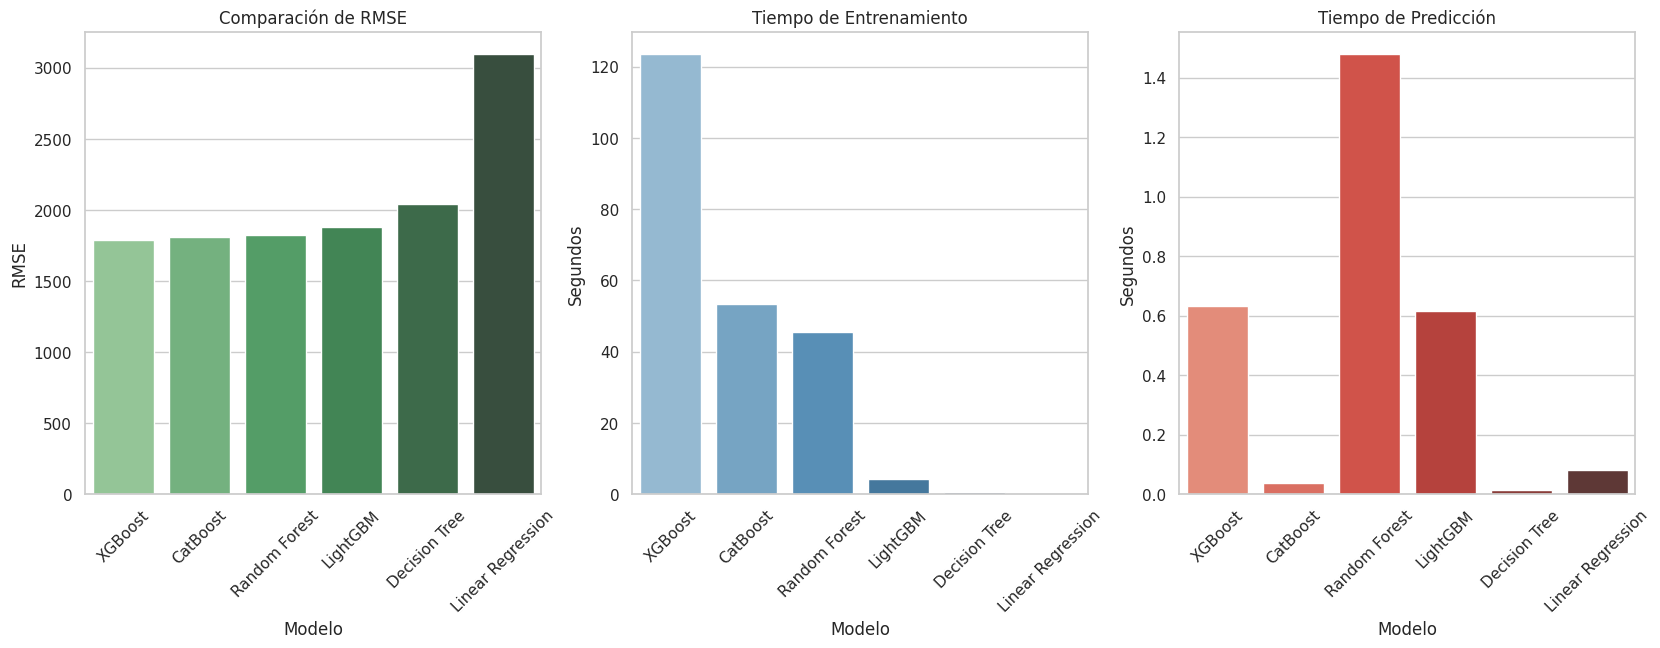

In [98]:
# Realizamos un grafico para visualizar los resultados

# Creamos una  figura con subplots para  que RMSE, Tiempo de Entrenamiento y Predicción se vean en una sola linea 
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Gráfico de RMSE
sns.barplot(data=df_results, x='Modelo', y='RMSE', ax=axes[0], palette='Greens_d')
axes[0].set_title('Comparación de RMSE')
axes[0].set_ylabel('RMSE')
axes[0].set_xlabel('Modelo')
axes[0].tick_params(axis='x', rotation=45)

# Gráfico de Tiempo de Entrenamiento
sns.barplot(data=df_results, x='Modelo', y='Tiempo de Entrenamiento (s)', ax=axes[1], palette='Blues_d')
axes[1].set_title('Tiempo de Entrenamiento')
axes[1].set_ylabel('Segundos')
axes[1].set_xlabel('Modelo')
axes[1].tick_params(axis='x', rotation=45)

# Gráfico de Tiempo de Predicción
sns.barplot(data=df_results, x='Modelo', y='Tiempo de Predicción (s)', ax=axes[2], palette='Reds_d')
axes[2].set_title('Tiempo de Predicción')
axes[2].set_ylabel('Segundos')
axes[2].set_xlabel('Modelo')
axes[2].tick_params(axis='x', rotation=45)

# Mostramos los gráficos
plt.show()

La regresión lineal es muy rápida tanto en el entrenamiento como en la predicción, pero la precisión es baja (RMSE alto). Esto era de esperarse, ya que la regresión lineal es un modelo simple y no captura relaciones complejas en los datos. este nos sirve como prueba de cordura.

El árbol de decisión mejora notablemente respecto a la regresión lineal. Sin embargo, su rendimiento aún es inferior al de modelos más avanzados como los basados en potenciación del gradiente.

El bosque aleatorio reduce el RMSE en comparación con el árbol de decisión, lo que indica que la agregación de varios árboles mejora la precisión. Sin embargo, su tiempo de entrenamiento y predicción es considerablemente mayor.

LightGBM logra una buena precisión con tiempos de entrenamiento rápidos en comparación con el bosque aleatorio y el ajuste de hiperparámetros mejora ligeramente el rendimiento.

XGBoost nos da una buena precisión, pero su tiempo de entrenamiento es significativamente más largo. el ajuste de los hiperparámetros mejora el RMSE, pero incrementa bastante el tiempo de entrenamiento.

CatBoost su tiempo de entrenamiento y predicción es competitivo, pero al ajustar los hiperparámetros reduce el RMSE a 1807.04, haciendo que incremente considerablemente el tiempo de entrenamiento.

## Conclusiones

- Fue fundamental llevar a cabo una preparación exhaustiva de los datos para garantizar un entrenamiento efectivo de los modelos. Se eliminaron columnas irrelevantes, se eliminaron valores duplicados y se abordaron los valores ausentes según su importancia. Todo esto se realizó para evitar complejidades innecesarias en el modelo y prevenir que se viera afectado por datos irrelevantes.


- De acuerdo a los resultados obtenidos, segun la velocidad de entrenamiento y predicción, CatBoost y LightGBM son significativamente más rápidos que XGBoost, especialmente en términos de predicción. XGBoost ofrece excelente precisión, pero a costa de tiempos de entrenamiento más largos.


- segun la calidad de las predicciones, XGBoost con hiperparámetros ajustados proporciona el mejor RMSE: 1787.18 (pero ofrece tiempos mas largos de entrenamiento). Bosque aleatorio y CatBoost también muestran un excelente desempeño, con RMSE cercanos.


- Teniendo en cuenta los intereses de Rusty Bargain que busca un equilibrio entre calidad de prediccion, velocidad de prediccion y tiempo de entrenamiento; Los modelos LightGBM y CatBoost ofrecen un equilibrio razonable entre calidad, velocidad y tiempo de entrenamiento. Sin embargo, se recomendaria a la empresa el uso de LightGBM ya que presenta un balance general con tiempos de entrenamiento y velocidad más bajos y precisión competitiva. esto garantizaria que la app funcione rápidamente y al mismo tiempo mantenga una buena precisión en la estimación del valor de mercado.